In [ ]:
# Standard libraries
import os

import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from tqdm import tqdm
import tqdm.notebook as tqdm_n
import seaborn as sns
from IPython.display import Markdown, display
import json
from datetime import datetime
import random

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import pytorch_lightning as pl

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

import src.dataloading as dataloading

2024-12-02 09:38:51.224692: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 09:38:51.250225: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 09:38:51.685760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'test_feather' from '/home/oskar/Documents/Jupyter/Sentinel/test_feather.py'>

# Load data

In [2]:
dfs = {}
for year in tqdm(range(2017, 2022)):
    path = "data/full_data/processed/processed_" + str(year) + ".feather"#"data/full_data/processed/" + str(year) + "_export_date_2024-03-25.feather"
    df = pd.read_feather(path)
    f = open(path.replace(".feather", ".json"), "r")
    correlation_filters = json.load(f)
    f.close()

    if 'level_0' in df.columns:
        df = df.drop(columns=['level_0'])

    df = df.reset_index()
    pmap = np.array(list(set(df['polygon_id'])))
    #polygons = [1000 + np.where(np.array(pmap) == i)[0][0] for i in df['polygon_id']]
    #df['polygon_id'] = polygons
    dfs[str(year)] = df


100%|██████████| 5/5 [00:51<00:00, 10.25s/it]


# Match data

In [3]:
def get_circle(pdf):
    cx = np.mean(pdf.x)
    cy = np.mean(pdf.y)
    r  = np.sqrt(np.max((pdf.x-cx)**2 + (pdf.y-cy)**2))
    return (cx, cy, r)

def intersecting(c1, c2):
    dx = c1[0]-c2[0]
    dy = c1[1]-c2[1]
    return dx*dx + dy*dy < (c1[2] + c2[2])**2
            
def get_point_set(year, polygon_id):
    df = dfs[year]
    return set([(p[0], p[1]) for p in list(df.loc[df['polygon_id'] == polygon_id, ['x', 'y']].astype(int).values)])   

In [4]:
     

def match_fields(id1, id2):
    if (id1 not in pid2match) and (id2 not in pid2match):
        # Assign both
        match2pid.append([id1, id2])
        pid2match[id1] = len(match2pid)-1
        pid2match[id2] = len(match2pid)-1
    elif (id1 not in pid2match):
        # Assign id1
        match2pid[pid2match[id2]].append(id1)
        pid2match[id1] = pid2match[id2]
    elif (id2 not in pid2match):
        # Assign id2
        match2pid[pid2match[id1]].append(id2)
        pid2match[id2] = pid2match[id1]
    elif pid2match[id1] != pid2match[id2]:
        # Reassign id2 to id1
        mpid1 = pid2match[id1]
        mpid2 = pid2match[id2]
        stash = match2pid[mpid2]
        for y, pid in stash:
            id = (y, pid)
            match2pid[mpid1].append(id)
            pid2match[id] = pid2match[id1]
        match2pid[mpid2] = []


for year in dfs:
    df = dfs[year]
    df['matching_pid'] = np.nan*np.zeros(df.shape[0])

intersections = []
overlap_history = {'match': [], 'no_match': []}
match2pid = []
pid2match = {}
new_pid_counter = 0
pbar_y1 = tqdm_n.tqdm(dfs)

for year1 in pbar_y1:
    pbar_y2 = tqdm_n.tqdm(dfs, leave=False)
    for year2 in pbar_y2:
        if year1 >= year2: continue
        
        df1 = dfs[year1]
        df2 = dfs[year2]
        pbar_pid1 = tqdm_n.tqdm(set(df1['based_on_pid']), leave=False)
        for pid1 in pbar_pid1:
            
            pdf1 = None
            set1 = None 
            c1 = None
            
            #pbar_pid2 = tqdm_n.tqdm(set(df2['based_on_pid']), leave=False)
            for pid2 in set(df2['based_on_pid']):
                
                # Match if matching by id
                if pid1 == pid2:
                    #print("match! same id", pid1, pid2)
                    match_fields((year1, pid1), (year2, pid2))
                    continue
                
                
                # check if overlapping bounding circles
                if pdf1 is None:
                    pdf1 = df1[df1['based_on_pid'] == pid1]
                    c1 = get_circle(pdf1)
                pdf2 = df2[df2['based_on_pid'] == pid2]
                c2 = get_circle(pdf2)
                if intersecting(c1, c2):
                    if set1 is None: set1 = set([(p[0], p[1]) for p in list(pdf1[['x', 'y']].astype(int).values)])
                    set2 = set([(p[0], p[1]) for p in list(pdf2[['x', 'y']].astype(int).values)])
                    
                    # Match if any points overlap
                    inter = len(set1.intersection(set2))
                    union = len(set1.union(set2))
                    intermetric = inter/np.sqrt(union)
                    if inter > 0: 
                        intersections.append(np.log(intermetric))
                        if inter <= 10: 
                            overlap_history['no_match'].append((pid1, pid2, intermetric, inter, union))
                    if inter > 10:
                        overlap_history['match'].append((pid1, pid2, intermetric, inter, union))
                        match_fields((year1, pid1), (year2, pid2))
                        
              

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
a = pid2match[("2021", 1202303)]
a, match2pid[a]


(17,
 [('2017', 1163868),
  ('2018', 1163868),
  ('2019', 1163868),
  ('2020', 1163868),
  ('2021', 1163868),
  ('2021', 1202303)])

In [6]:
np.max([x[3] for x in overlap_history['no_match']]), np.min([x[3] for x in overlap_history['match']])

(10, 11)

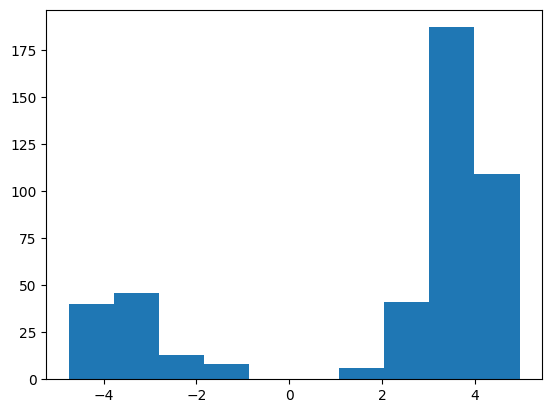

In [7]:
plt.hist(intersections);

## Check overmatching

In [8]:
A = [x for x in match2pid if len(x) > 5]
A

[[('2017', 3755084),
  ('2018', 3755084),
  ('2018', 2532170),
  ('2017', 2532170),
  ('2019', 3755084),
  ('2019', 2532170),
  ('2020', 1497669),
  ('2021', 3755084),
  ('2021', 2532170)],
 [('2017', 1163868),
  ('2018', 1163868),
  ('2019', 1163868),
  ('2020', 1163868),
  ('2021', 1163868),
  ('2021', 1202303)],
 [('2017', 2583750),
  ('2018', 2583750),
  ('2019', 2583750),
  ('2019', 2583752),
  ('2020', 2583750),
  ('2020', 2583752),
  ('2021', 283585),
  ('2021', 283588)],
 [('2017', 3357963),
  ('2018', 3357963),
  ('2019', 3357963),
  ('2020', 2146863),
  ('2020', 581075),
  ('2021', 2146863),
  ('2021', 581075)],
 [('2017', 4105088),
  ('2018', 4105088),
  ('2019', 2349229),
  ('2019', 2349302),
  ('2020', 2349229),
  ('2020', 2349302),
  ('2021', 2349229),
  ('2021', 2349302)],
 [('2017', 3761086),
  ('2018', 3761086),
  ('2019', 2743762),
  ('2020', 3761086),
  ('2021', 3761086),
  ('2020', 326361),
  ('2021', 326361)],
 [('2018', 2759220),
  ('2019', 2759220),
  ('2017', 41

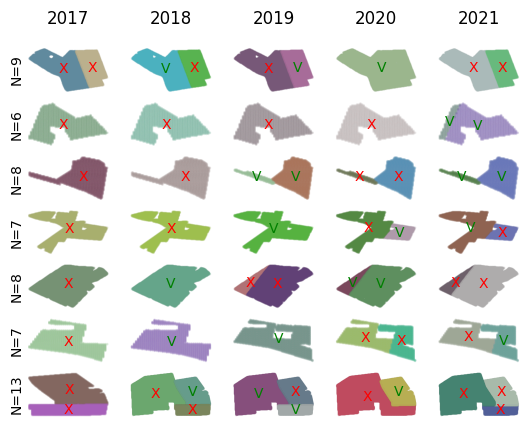

In [9]:

fig, axs = plt.subplots(len(A),5)
for j, s in enumerate(A):
    for i, (y, pid) in enumerate(s):
        df = dfs[y]
        pdf = df[df['based_on_pid'] == pid]
        
        ax = axs[j, int(y)-2017]
        c = (int(y)-2016)*np.ones(pdf.shape[0])
        c = list(np.random.rand(3)*0.5 + 0.25) + [1]
        c = [c for i in range(pdf.shape[0])]
        ax.scatter(pdf.x, pdf.y, c=c, s=1, alpha=0.2)
        
        cx = np.mean(pdf.x)
        cy = np.mean(pdf.y)
        if np.mean(np.isnan(pdf['yield'])) < 1:
            ax.text(cx, cy, "V", color="green", ha="center", va="center")
        else:
            ax.text(cx, cy, "X", color="red", ha="center", va="center")
        #x, y = (391266, 6164445)
        #d = 100
        #ax.set_xlim(x-d, x+d)
        #ax.set_ylim(y-d, y+d)
        #ax.scatter(x, y, s=5, marker='.')
        
for i in range(5): 
    for j in range(len(A)):
        axs[j, i].axis('off')

for i in range(5):
    axs[0, i].set_title(str(i+2017))
    
for i in range(len(A)):
    axs[i, 0].text(-0.1, 0.5, "N=" + str(len(A[i])), transform=axs[i, 0].transAxes, ha="center", va="center", rotation="vertical")

## Check undermatching

In [10]:
A = [x for x in match2pid if len(x) < 5 and len(x) > 0]
len(A)

15

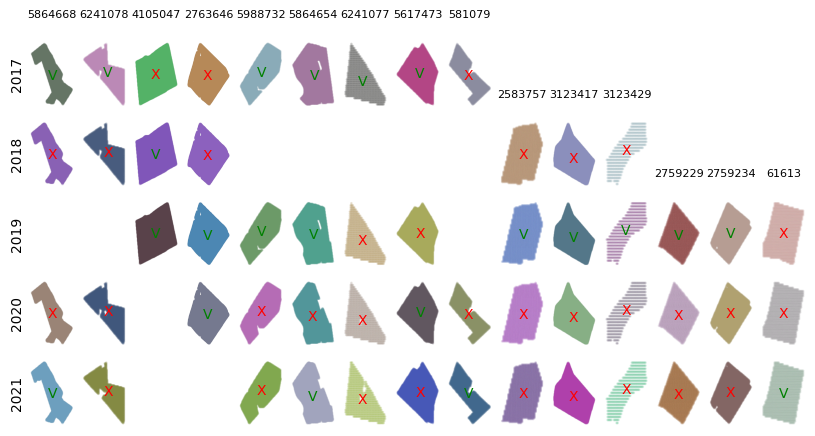

In [11]:

fig = plt.figure(figsize=(10, 5))
axs = fig.subplots(5, len(A))
done = np.zeros((5,len(A)))
ids = np.zeros((5,len(A)))
for j, s in enumerate(A):
    for i, (y, pid) in enumerate(s):
        df = dfs[y]
        pdf = df[df['based_on_pid'] == pid]
        
        ax = axs[int(y)-2017, j]
        done[int(y)-2017, j] = 1
        c = (int(y)-2016)*np.ones(pdf.shape[0])
        c = list(np.random.rand(3)*0.5 + 0.25) + [1]
        c = [c for i in range(pdf.shape[0])]
        ax.scatter(pdf.x, pdf.y, c=c, s=1, alpha=0.2)
        
        ids[int(y)-2017, j] = pid
        
        cx = np.mean(pdf.x)
        cy = np.mean(pdf.y)
        if np.mean(np.isnan(pdf['yield'])) < 1:
            ax.text(cx, cy, "V", color="green", ha="center", va="center")
        else:
            ax.text(cx, cy, "X", color="red", ha="center", va="center")
        #x, y = (391266, 6164445)
        #d = 100
        #ax.set_xlim(x-d, x+d)
        #ax.set_ylim(y-d, y+d)
        #ax.scatter(x, y, s=5, marker='.')

for i in range(5): 
    for j in range(len(A)):
        axs[i, j].axis('off')
        
for i in range(5):
    axs[i, 0].text(-0.3, 0.5, str(i+2017), transform=axs[i, 0].transAxes, ha="center", va="center", rotation="vertical")
    
for i in range(len(A)):
    id = int(ids[0, i])
    j = 0
    if id == 0: 
        id = int(ids[1, i])
        j = 1
    if id == 0: 
        id = int(ids[2, i])
        j = 2
    axs[j, i].set_title(id, fontsize=8)
    

390946.29 392086.29 6163535.56 6164455.56


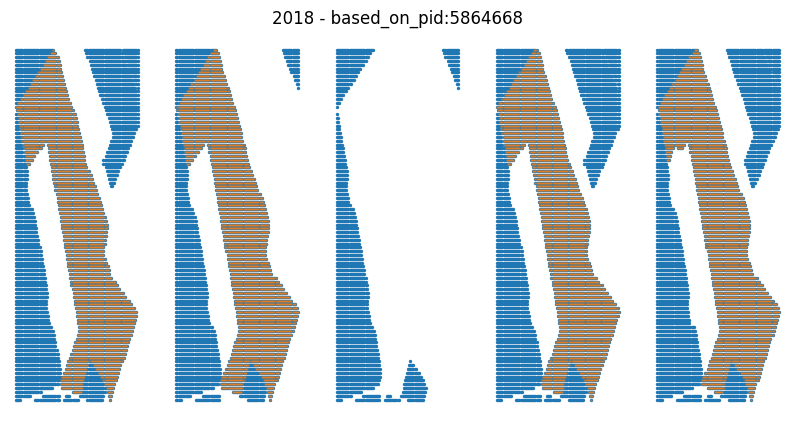

In [13]:
# example
s = A[0]

fig = plt.figure(figsize=(10, 5))
plt.title(s[1][0] + " - based_on_pid:" + str(s[1][1]))
plt.axis('off')
axs = fig.subplots(1, 5)
max_x = max([np.max(dfs[y].loc[dfs[y]['based_on_pid'] == pid, 'x']) for y, pid in s])
min_x = min([np.min(dfs[y].loc[dfs[y]['based_on_pid'] == pid, 'x']) for y, pid in s])
max_y = max([np.max(dfs[y].loc[dfs[y]['based_on_pid'] == pid, 'y']) for y, pid in s])
min_y = min([np.min(dfs[y].loc[dfs[y]['based_on_pid'] == pid, 'y']) for y, pid in s])
print(min_x, max_x, min_y, max_y)

for y in dfs:
    df = dfs[y]
    df = df[(df.x <= max_x) & (df.x >= min_x) & (df.y <= max_y) & (df.y >= min_y)]
    i = int(y)-2017
    ax = axs[i]
    ax.scatter(df.x, df.y, s=2)
    ax.axis('off')
    

for y, pid in s:
    df = dfs[y]
    pdf = df[df['based_on_pid'] == pid]
    i = int(y)-2017
    ax = axs[i]
    ax.scatter(pdf.x, pdf.y, s=.5, alpha=0.5)
    ax.axis('off')
    

## Check full matching

In [14]:
A = [x for x in match2pid if len(x) == 5]
len(A)

130

In [15]:
for a in A:
    v = [i[0] for i in a]
    if v != ['2017', '2018', '2019', '2020', '2021']:
        print(v)

4


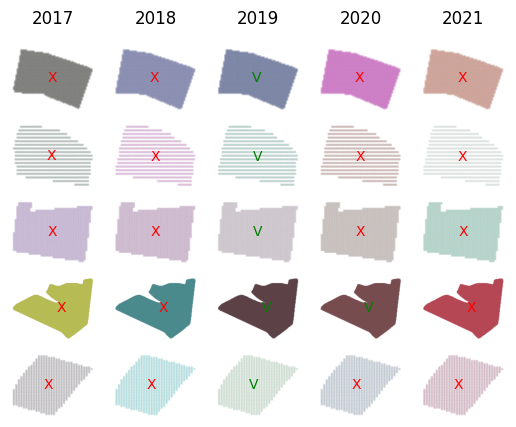

In [16]:
A = A[:5]

print(len(s))
fig, axs = plt.subplots(len(A),5)
for j, s in enumerate(A):
    for i, (y, pid) in enumerate(s):
        df = dfs[y]
        pdf = df[df['based_on_pid'] == pid]
        
        ax = axs[j, int(y)-2017]
        c = (int(y)-2016)*np.ones(pdf.shape[0])
        c = list(np.random.rand(3)*0.5 + 0.25) + [1]
        c = [c for i in range(pdf.shape[0])]
        ax.scatter(pdf.x, pdf.y, c=c, s=1, alpha=0.2)
        
        cx = np.mean(pdf.x)
        cy = np.mean(pdf.y)
        if np.mean(np.isnan(pdf['yield'])) < 1:
            ax.text(cx, cy, "V", color="green", ha="center", va="center")
        else:
            ax.text(cx, cy, "X", color="red", ha="center", va="center")
        #x, y = (391266, 6164445)
        #d = 100
        #ax.set_xlim(x-d, x+d)
        #ax.set_ylim(y-d, y+d)
        #ax.scatter(x, y, s=5, marker='.')
        
for i in range(5): 
    for j in range(len(A)):
        axs[j, i].axis('off')

for i in range(5):
    axs[0, i].set_title(str(i+2017))
    
#for i in range(len(A)):
#    axs[i, 0].text(-0.1, 0.5, "N=" + str(len(A[i])), transform=axs[i, 0].transAxes, ha="center", va="center", rotation="vertical")

In [17]:
len([x for x in match2pid if len(x) > 0])

152

# Merge Years

In [18]:
match2pid = [x for x in match2pid if len(x) != 0]

In [22]:

for year in dfs:
    df = dfs[year]
    if "matching_pid" not in df.columns:
        dfs[year] = df.insert(4, "matching_pid", np.nan*np.zeros(df.shape[0]).astype(int))

In [23]:
for i, s in enumerate(match2pid):
    for year, pid in s:
        df = dfs[year]
        df.loc[df['based_on_pid'] == pid, "matching_pid"] = i

for year in dfs:
    df = dfs[year]
    df.loc[np.isnan(df['matching_pid']), 'matching_pid'] = df.loc[np.isnan(df['matching_pid']), 'based_on_pid']
    df['matching_pid'] = df['matching_pid'].astype(int)

In [28]:
dfs['2018']

,level_0,index,polygon_id,based_on_pid,grdkod_mar,x,y,elevation,slope,yield,...,topology_2,topology_3,topology_4,topology_5,topology_6,topology_7,topology_8,topology_9,topology_10,matching_pid
0,0,0,3755105,3755105,4,391196.29,6163545.56,15.997082,6.927336,NaN,...,0,0,0,0,0,0,1,0,0,20
1,1,1,3755105,3755105,4,391206.29,6163545.56,15.907708,6.488183,NaN,...,0,0,0,0,0,0,1,0,0,20
2,2,2,3755105,3755105,4,391216.29,6163545.56,15.692196,5.908475,NaN,...,0,0,0,0,0,0,1,0,0,20
3,3,3,3755105,3755105,4,391226.29,6163545.56,15.376491,5.316551,NaN,...,0,0,0,0,0,0,1,0,0,20
4,4,4,3755105,3755105,4,391236.29,6163545.56,14.937154,4.814449,NaN,...,0,0,0,0,0,0,1,0,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373648,373648,8159,4820676,5988735,2,390544.49,6181574.31,31.629727,0.584617,NaN,...,0,0,0,0,0,0,0,0,0,117
373649,373649,8160,4820676,5988735,2,390354.49,6181564.31,33.393630,0.863802,NaN,...,0,0,0,0,0,0,0,0,0,117
373650,373650,8161,4820676,5988735,2,390534.49,6181564.31,31.733251,0.750503,NaN,...,0,0,0,0,0,0,0,0,0,117
373651,373651,8162,4820676,5988735,2,390544.49,6181564.31,31.600355,1.042238,NaN,...,0,0,0,0,0,0,0,0,0,117


In [29]:

for year in dfs:
    df = dfs[year]
    if 'year' not in df.columns:
        df.insert(3, 'year', (np.ones(df.shape[0])*int(year)).astype(int))

In [31]:
mega = pd.DataFrame()
for year in dfs:
    df = dfs[year]
    mega = pd.concat([mega, df])

In [43]:
cols = list(mega.columns)
cols.remove('level_0')
cols.remove('year')
cols.remove('matching_pid')
cols = cols[:1] + ['year'] + cols[1:3] + ['matching_pid'] + cols[3:]
mega_df = mega[cols]

In [47]:
display(mega_df.head())
display(mega_df.describe())

,index,year,polygon_id,based_on_pid,matching_pid,grdkod_mar,x,y,elevation,slope,...,topology_1,topology_2,topology_3,topology_4,topology_5,topology_6,topology_7,topology_8,topology_9,topology_10
0,0,2017,5432790,1340050,27,20,415395.09,6171035.16,37.030882,3.419059,...,1,0,0,0,0,0,0,0,0,0
1,1,2017,5432790,1340050,27,20,415405.09,6171035.16,37.388691,4.120628,...,1,0,0,0,0,0,0,0,0,0
2,2,2017,5432790,1340050,27,20,415385.09,6171025.16,36.573299,1.446604,...,1,0,0,0,0,0,0,0,0,0
3,3,2017,5432790,1340050,27,20,415395.09,6171025.16,36.680923,1.860729,...,1,0,0,0,0,0,0,0,0,0
4,4,2017,5432790,1340050,27,20,415405.09,6171025.16,36.893785,2.851630,...,1,0,0,0,0,0,0,0,0,0


,index,year,polygon_id,based_on_pid,matching_pid,grdkod_mar,x,y,elevation,slope,...,topology_1,topology_2,topology_3,topology_4,topology_5,topology_6,topology_7,topology_8,topology_9,topology_10
count,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,...,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06,1.898084e+06
mean,2.703970e+03,2.019006e+03,2.999010e+06,3.444178e+06,1.611531e+03,1.302495e+01,3.974681e+05,6.173022e+06,4.482885e+01,1.707183e+00,...,3.989808e-01,2.372392e-03,2.454317e-02,1.214498e-01,3.415971e-02,2.540673e-01,2.584554e-02,1.141593e-01,2.345365e-02,9.683449e-04
std,3.213474e+03,1.409291e+00,1.913239e+06,1.746632e+06,5.803209e+04,1.624547e+01,1.021333e+04,6.955039e+03,2.288674e+01,1.396818e+00,...,4.896889e-01,4.864941e-02,1.547282e-01,3.266494e-01,1.816393e-01,4.353357e-01,1.586744e-01,3.180048e-01,1.513393e-01,3.110318e-02
min,0.000000e+00,2.017000e+03,6.160800e+04,6.160800e+04,0.000000e+00,2.000000e+00,3.859350e+05,6.161711e+06,7.129870e+00,6.247012e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.650000e+02,2.018000e+03,1.351759e+06,2.400504e+06,4.300000e+01,4.000000e+00,3.907255e+05,6.165676e+06,2.954155e+01,7.086414e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.583000e+03,2.019000e+03,2.763638e+06,3.123443e+06,8.400000e+01,4.000000e+00,3.921742e+05,6.173223e+06,3.687099e+01,1.340265e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.476000e+03,2.020000e+03,4.105088e+06,4.687713e+06,1.140000e+02,2.000000e+01,3.992650e+05,6.180138e+06,5.934850e+01,2.279844e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.035700e+04,2.021000e+03,6.241086e+06,6.241086e+06,2.198937e+06,6.000000e+01,4.226358e+05,6.183556e+06,1.141851e+02,1.529220e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
mega_df.to_feather("data/full_data/processed/processed_merged.feather")

In [ ]:

correlation_filter_thresholds = [0.5, 0.9, 0.99]
min_correlation = 0.1
correlation_filters = dataloading.filter_features(mega_df[np.isnan(mega_df['yield']) == False], correlation_filter_thresholds, min_correlation)


f = open("data/full_data/processed/processed_merged.json", "w")
json.dump(correlation_filters, f)
f.close()